In [1]:
import os
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import graphviz

# User-defined functions
def model_summary(y_test, dtc_predict, dtc_cv_score):
    print("=== Confusion Matrix ===")
    print(confusion_matrix(y_test, dtc_predict))
    print('\n')
    print("=== Classification Report ===")
    print(classification_report(y_test, dtc_predict))
    print('\n')
    print("=== All AUC Scores ===")
    print(dtc_cv_score)
    print('\n')
    print("=== Mean AUC Score ===")
    print("Mean AUC Score - Random Forest: ", dtc_cv_score.mean())


In [14]:
# Import and prepare data

# FICO Home Equity Line of Credit (HELOC) Dataset (https://community.fico.com/s/explainable-machine-learning-challenge)
heloc = pd.read_csv('heloc_dataset_v1.csv')

# The target variable to predict is a binary variable called RiskPerformance. 
heloc.loc[heloc['RiskPerformance']=='Good','Risk'] = 0
heloc.loc[heloc['RiskPerformance']=='Bad','Risk'] = 1
heloc.drop(columns=['RiskPerformance'], inplace=True)

# Define predcitors and target variable
X = heloc.drop(columns=['Risk'])
y = heloc['Risk']
feature_names = X.columns
target_names = ['Good', 'Bad']

# Implement train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=66)

In [15]:
heloc.groupby('Risk')['Risk'].count()

Risk
0.0    5000
1.0    5459
Name: Risk, dtype: int64

=== Confusion Matrix ===
[[1032  630]
 [ 411 1379]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.72      0.62      0.66      1662
         1.0       0.69      0.77      0.73      1790

    accuracy                           0.70      3452
   macro avg       0.70      0.70      0.70      3452
weighted avg       0.70      0.70      0.70      3452



=== All AUC Scores ===
[0.77109707 0.57989194 0.7780641  0.75671795 0.77451832 0.81778571
 0.76397619 0.70969597 0.78972711 0.80221284]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.7543687203011056


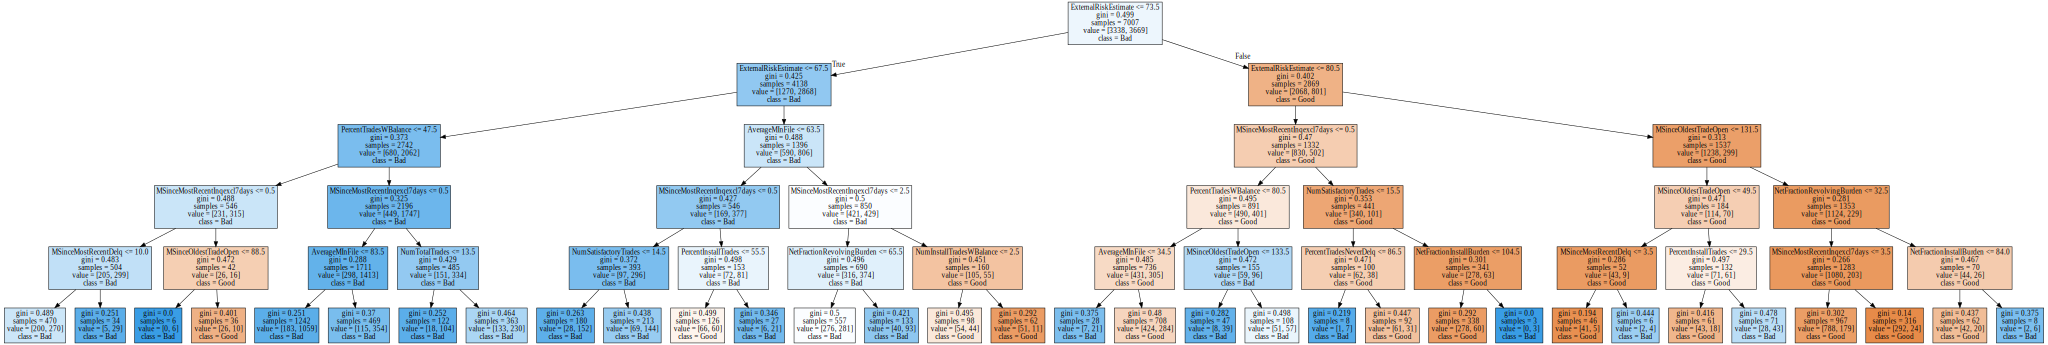

In [4]:
# Create a simple tree model
dtc = tree.DecisionTreeClassifier(max_depth=5)
dtc = dtc.fit(X_train, y_train)
dtc_predict = dtc.predict(X_test) # predictions
dtc_cv_score = cross_val_score(dtc, X, y, cv=10, scoring='roc_auc') #scores

# Model summary
model_summary(y_test, dtc_predict, dtc_cv_score)

#tree.plot_tree(dtc)
dot_data = tree.export_graphviz(dtc, feature_names=feature_names, class_names=target_names, 
                                out_file=None, filled = True)
graph = graphviz.Source(dot_data)
graph

In [5]:
# Create a Random Forest Model

rfc = RandomForestClassifier()
rfc.fit(X_train,y_train) #fit
rfc_predict = rfc.predict(X_test) # predictions
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc') #scores

# Model summary
model_summary(y_test, rfc_predict, rfc_cv_score)

=== Confusion Matrix ===
[[1082  580]
 [ 411 1379]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.72      0.65      0.69      1662
         1.0       0.70      0.77      0.74      1790

    accuracy                           0.71      3452
   macro avg       0.71      0.71      0.71      3452
weighted avg       0.71      0.71      0.71      3452



=== All AUC Scores ===
[0.78368498 0.62908974 0.80382601 0.77019597 0.78352381 0.82434799
 0.79663187 0.73405128 0.81208425 0.82542752]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.7762863420371676


In [6]:
# Tuning Hyperparameters

# Optimize select hyperparamaters
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)] # number of trees in random forest
max_features = ['auto', 'sqrt'] # number of features at every split
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)] # max depth
max_depth.append(None)

# Create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }

# Random search of parameters
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, 
                                cv = 3, verbose=2, random_state=42, n_jobs = -1)
rfc_random.fit(X_train, y_train) # Fit the model
print(rfc_random.best_params_) # Print results


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 20.9min finished


{'n_estimators': 2000, 'max_features': 'sqrt', 'max_depth': 220}


In [18]:
# Final Model
# Refit the model with tuned parameters
rfc = RandomForestClassifier(n_estimators=500, max_depth=100, max_features='sqrt')
rfc.fit(X_train,y_train) #fit
rfc_predict = rfc.predict(X_test) # predictions
rfc_cv_score = cross_val_score(rfc, X, y, cv=10, scoring='roc_auc') #scores

# Model summary
model_summary(y_test, rfc_predict, rfc_cv_score)

=== Confusion Matrix ===
[[1087  575]
 [ 404 1386]]


=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.73      0.65      0.69      1662
         1.0       0.71      0.77      0.74      1790

    accuracy                           0.72      3452
   macro avg       0.72      0.71      0.71      3452
weighted avg       0.72      0.72      0.72      3452



=== All AUC Scores ===
[0.78716484 0.63935531 0.81069414 0.77591941 0.79377839 0.82780037
 0.79864835 0.73837912 0.81671245 0.82410092]


=== Mean AUC Score ===
Mean AUC Score - Random Forest:  0.7812553298383573


,Gini-importance
ExternalRiskEstimate,0.124767
MSinceOldestTradeOpen,0.068710
MSinceMostRecentTradeOpen,0.041777
AverageMInFile,0.079309
NumSatisfactoryTrades,0.050502


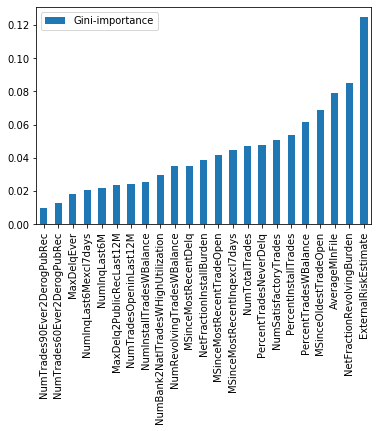

In [19]:
# Feature Importance

importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, rfc.feature_importances_):
    feats[feature] = importance 
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})

importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90) #Plot
importances.head() # Print the feature ranking